In [97]:
%load_ext autoreload
%autoreload 2

import torch
import tqdm
import gpytorch


import numpy as np
from ase import io
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.append("../../fande") # Adds higher directory to python modules path.
sys.path.append("..") # Adds higher directory to python modules path.

In [100]:
path = os.getcwd()

print(path)

/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks


In [545]:
from fande.data import FandeDataModule

### Parsing and loading data:

In [15]:
%load_ext autoreload
%autoreload 2

from sdynamics.load import parse_trajectories, parse_forces, flatten_trj_dictionaries

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [625]:
trajectories, energies_trj, trj_files_basenames = parse_trajectories(traj_folder="../data/dynamics/ene_grad_fitting/data/trj/")
forces_trj = parse_forces(forces_path = '../data/dynamics/ene_grad_fitting/data/grad/', trj_files_basenames = trj_files_basenames)

Reading trajectory files...


100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

Trajectory files reading done!
Reading .npy files with forces...
Reading .npy files with forces done!


In [626]:
traj, energies, forces = flatten_trj_dictionaries(trajectories, energies_trj, trj_files_basenames, forces_trj)

Flattening done!


### Prepare training/test datasets:

In [1213]:
# Training data:
# training_indices = np.sort(  np.random.choice(np.arange(0,10_000), 1000, replace=False) )
training_indices = np.sort(  np.arange(0, 90000, 200) )  
traj_train = [traj[i] for i in training_indices]
energies_train = energies[training_indices]
forces_train = forces[training_indices]
train_data = {'trajectory': traj_train, 'energies': energies_train, 'forces': forces_train}

#Test data:
# test_indices = np.sort(  np.random.choice(np.arange(0,92795), 200, replace=False) ) 
test_indices = np.sort(  np.arange(1,101,2) ) 
traj_test = [traj[i] for i in test_indices]
energies_test = energies[test_indices]
forces_test = forces[test_indices]
test_data = {'trajectory': traj_test, 'energies': energies_test, 'forces': forces_test}

(450, 17, 3)


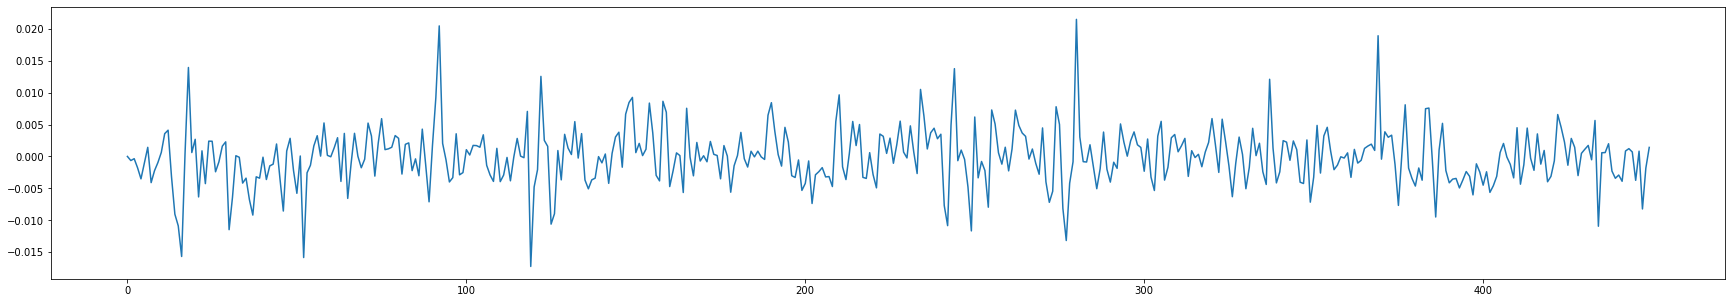

In [1214]:
from fande.data import FandeDataModuleASE


hparams = {
    'dtype' : 'float64',
    'device' : 'gpu'
}

del fdm

fdm = FandeDataModuleASE(train_data, test_data, hparams)

print(fdm.forces_train_norm.shape)
plt.plot(fdm.forces_train[:,16,0])

In [1215]:
soap_params = {
    'species': ["H", "C"],
    'periodic': False,
    'rcut': 3.0,
    'sigma': 0.5,
    'nmax': 5,
    'lmax': 5,
    'average': "outer",
    'crossover': True,
    'dtype': "float64",
    'n_jobs': 10,
    'sparse': False,
    'positions': [0,2,3,6]
}

fdm.calculate_invariants(soap_params)

Total length of train traj is 450
Starting SOAP calculation...
SOAP calculation done!
Total length of test traj is 50
Starting SOAP calculation...
SOAP calculation done!
(450, 17, 3, 330)
(450, 330)


In [1216]:
fdm.train_DX.shape

torch.Size([22950, 330])

### Fitting Forces:

In [1227]:
from fande.models import ModelForces, ModelEnergies, MyCallbacks
from torch.utils.data import DataLoader, TensorDataset, random_split
from pytorch_lightning import Trainer, seed_everything
import numpy as np
# seed_everything(42, workers=True)

train_DX = fdm.train_DX
train_F = fdm.train_F
test_DX = fdm.test_DX
test_F = fdm.test_F

# ind_slice = np.sort( np.concatenate( 
#     ( np.arange(0,4800), np.arange(11*4800,12*4800), np.random.choice(np.arange(4800,59200), 300, replace=False) ) 
#     ) )

ind_slice = np.sort(  np.random.choice(np.arange(0,train_F.shape[0]), 10_000, replace=False) ) 
# ind_slice = np.sort(  np.arange(0,2550) ) 
# ind_slice = np.sort(  np.arange(0,train_F.shape[0]) ) 


train_dataset = TensorDataset(train_DX[ind_slice], train_F[ind_slice])
train_loader = DataLoader(train_dataset, batch_size=100_000)

model_f = ModelForces(train_DX[ind_slice], train_F[ind_slice], hparams, 0.05)

trainer_f = Trainer(
    gpus=1, 
    max_epochs=150, 
    precision=64,
    weights_summary='full', 
    callbacks=[MyCallbacks()])

trainer_f.fit(model_f, train_loader)

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:394: UserWarning:

The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.




 setup() callback called...
Epoch 149: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=-1.71, v_num=190] 

 teardown() callback called...


### Predictions on test data:


 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...


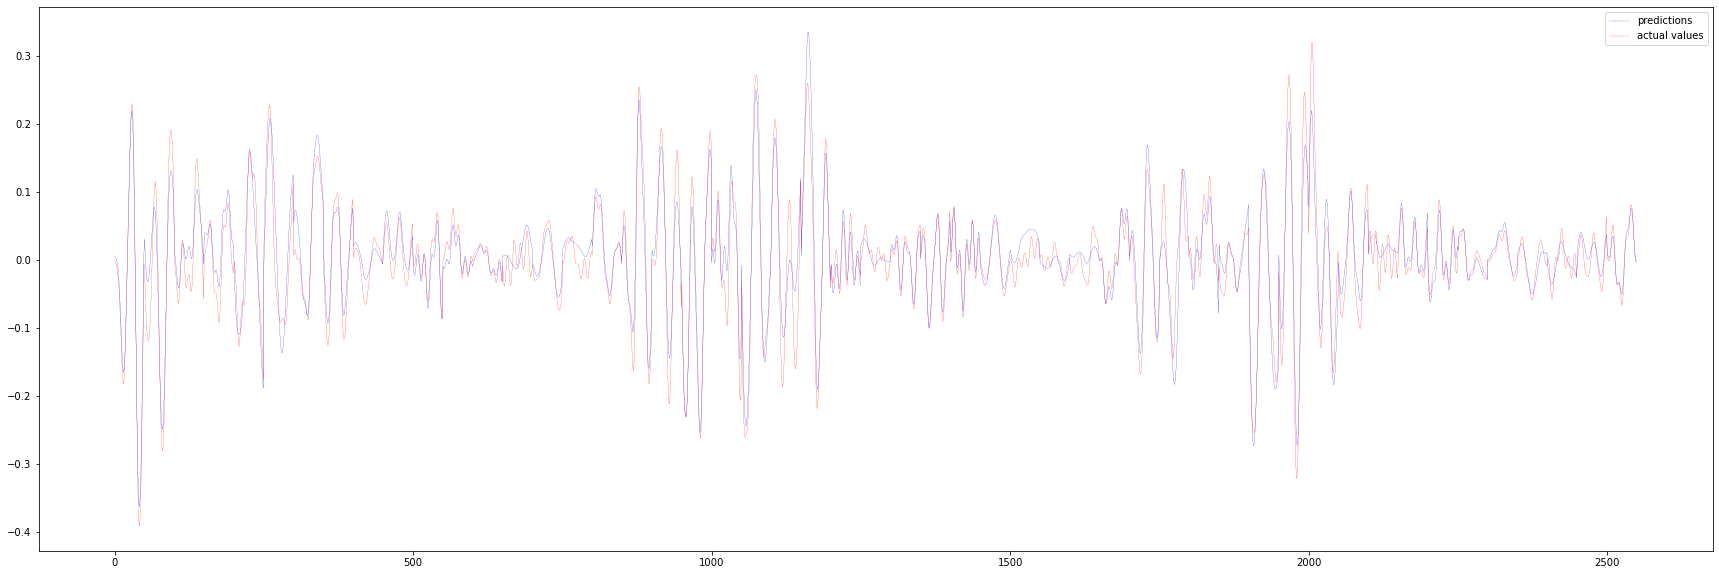

Forces MAE: 0.0198
Forces MSE: 0.0008


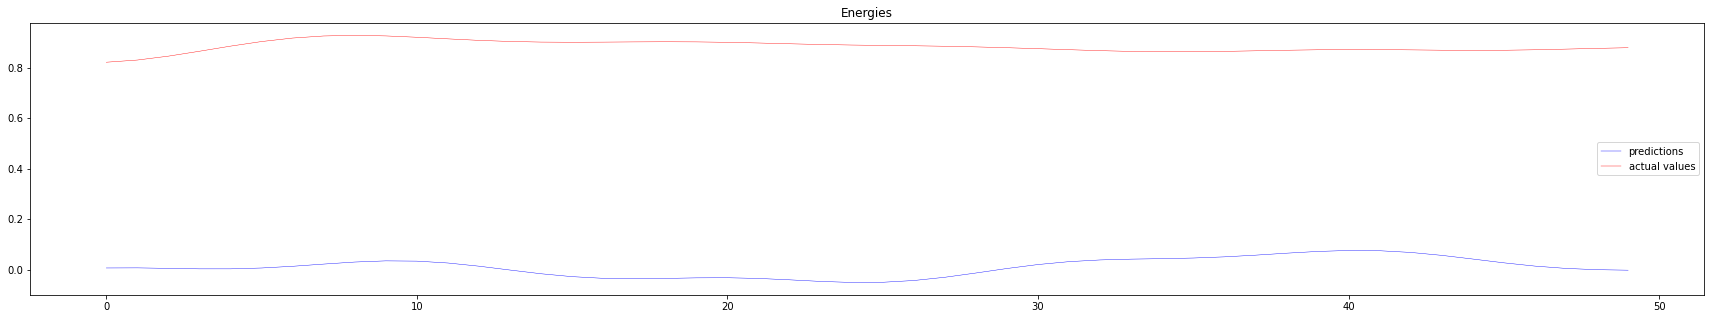

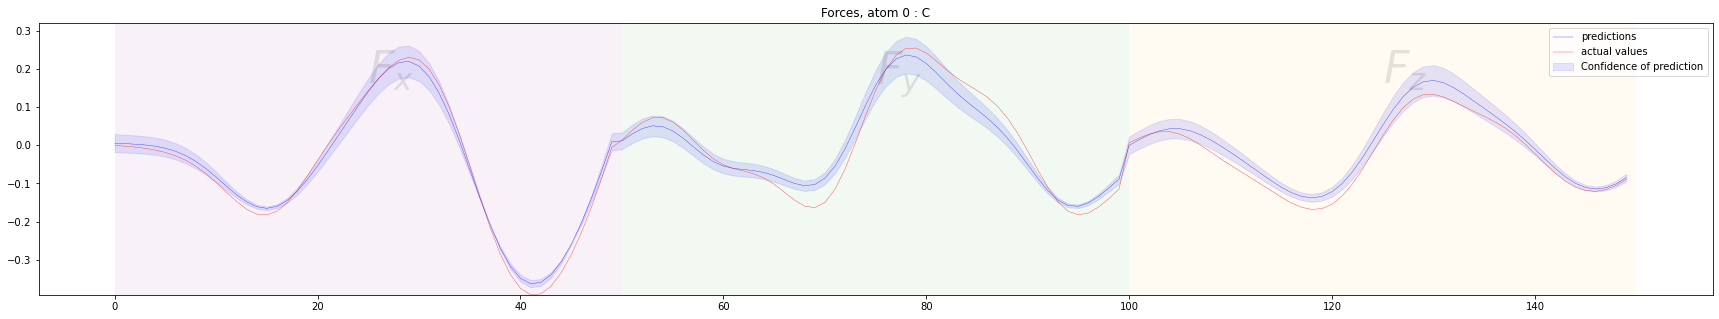

Forces MAE: 0.0210
Forces MSE: 0.0006
Cumulative uncertainty: 5.9252


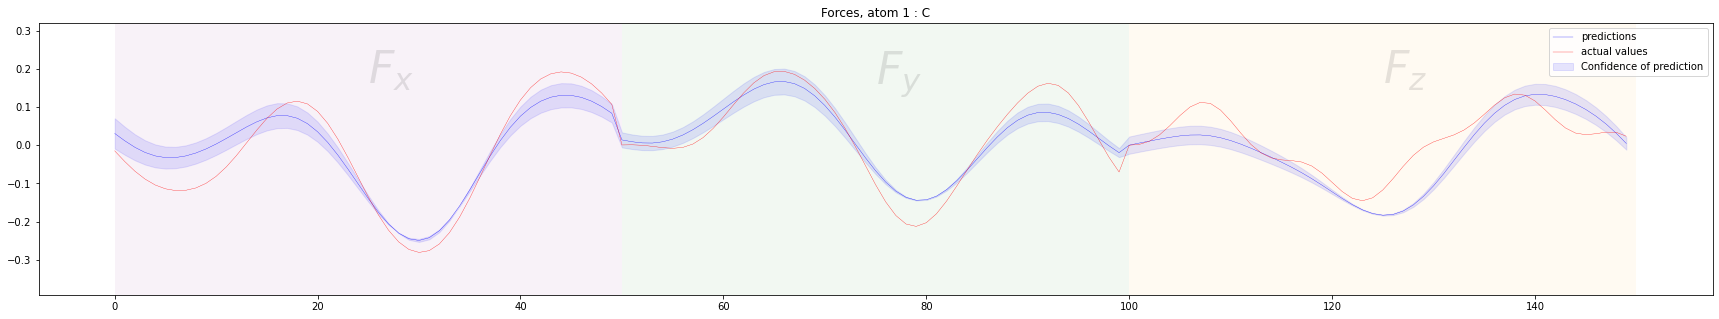

Forces MAE: 0.0391
Forces MSE: 0.0023
Cumulative uncertainty: 5.6808


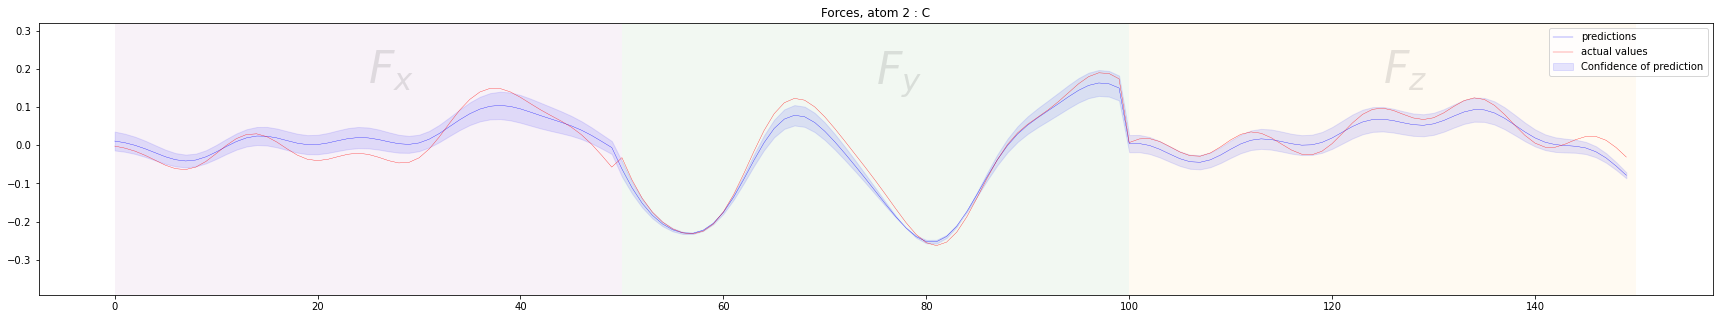

Forces MAE: 0.0208
Forces MSE: 0.0006
Cumulative uncertainty: 6.3334


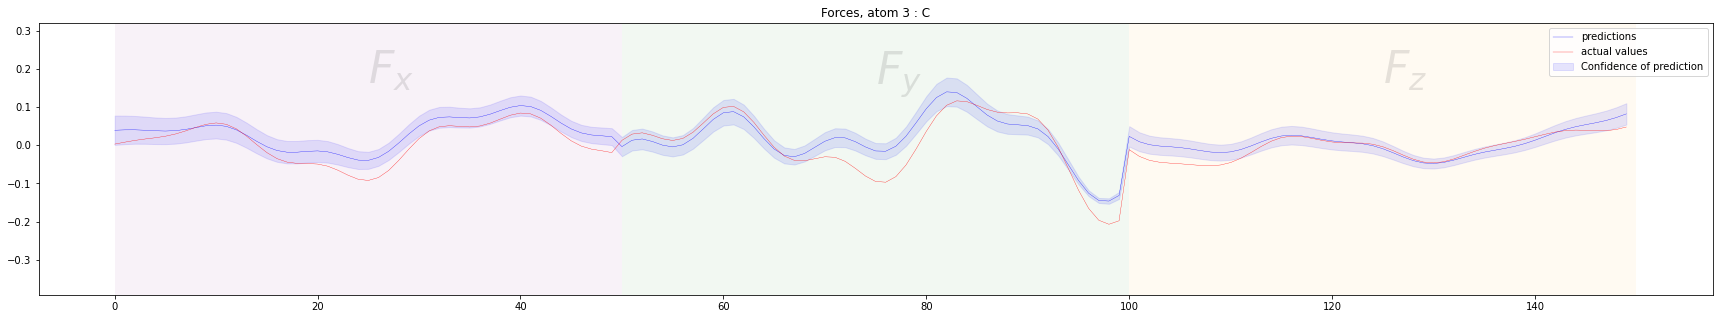

Forces MAE: 0.0243
Forces MSE: 0.0010
Cumulative uncertainty: 7.2992


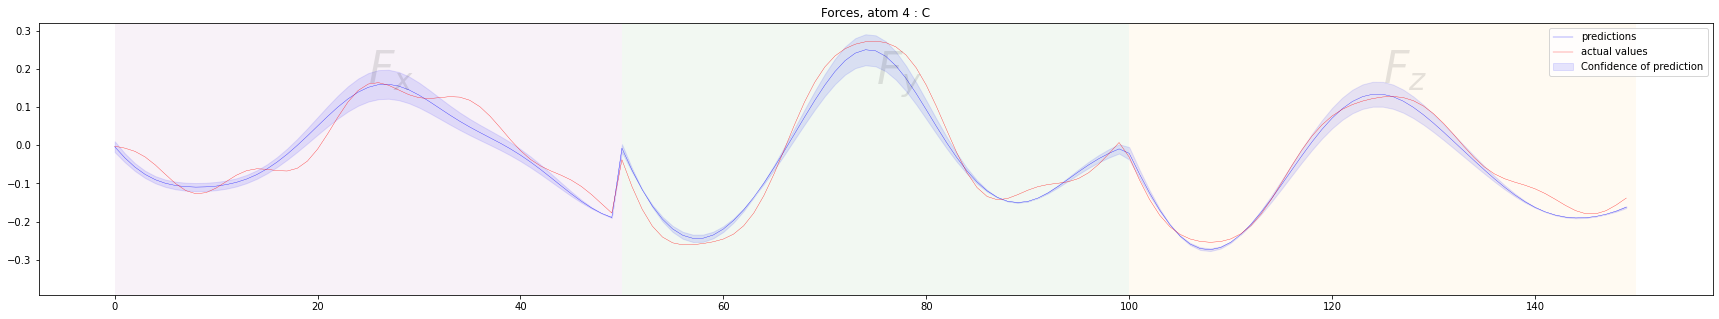

Forces MAE: 0.0234
Forces MSE: 0.0009
Cumulative uncertainty: 3.8852


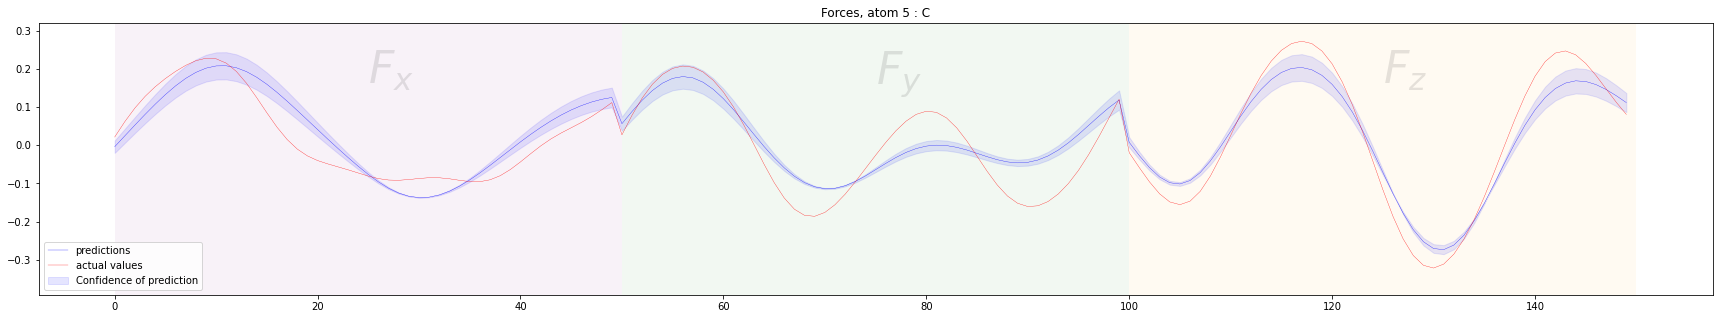

Forces MAE: 0.0463
Forces MSE: 0.0030
Cumulative uncertainty: 4.8343


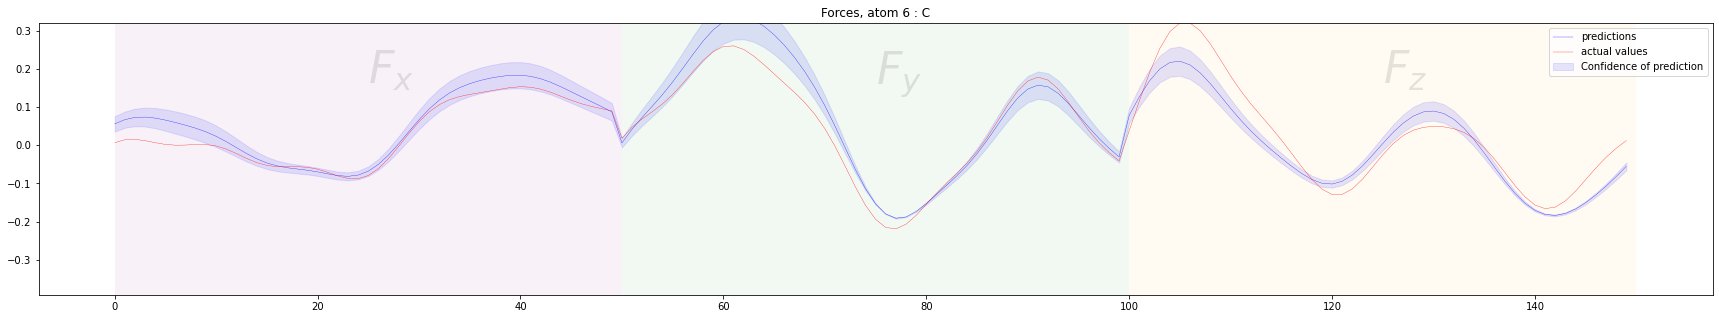

Forces MAE: 0.0339
Forces MSE: 0.0019
Cumulative uncertainty: 6.7180


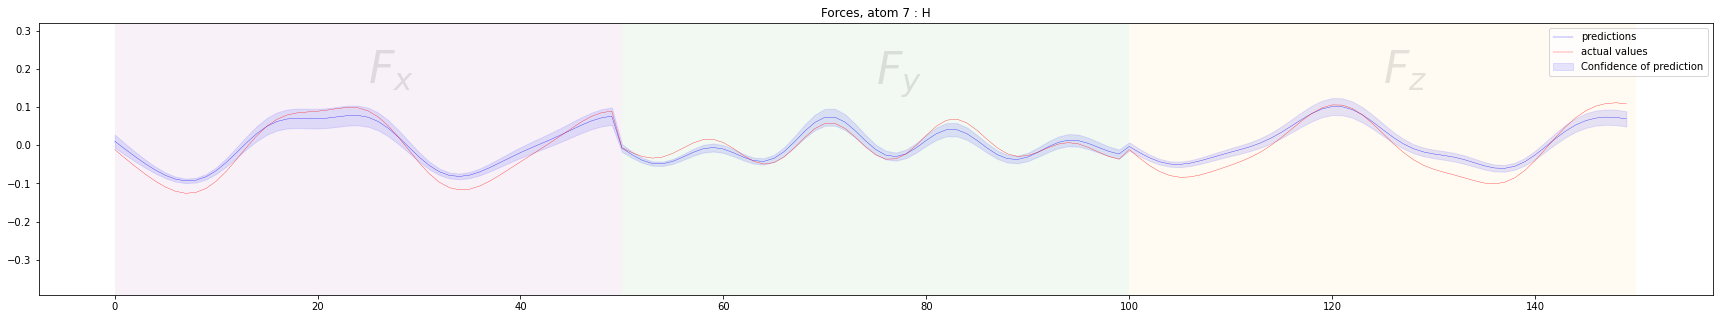

Forces MAE: 0.0190
Forces MSE: 0.0005
Cumulative uncertainty: 4.2103


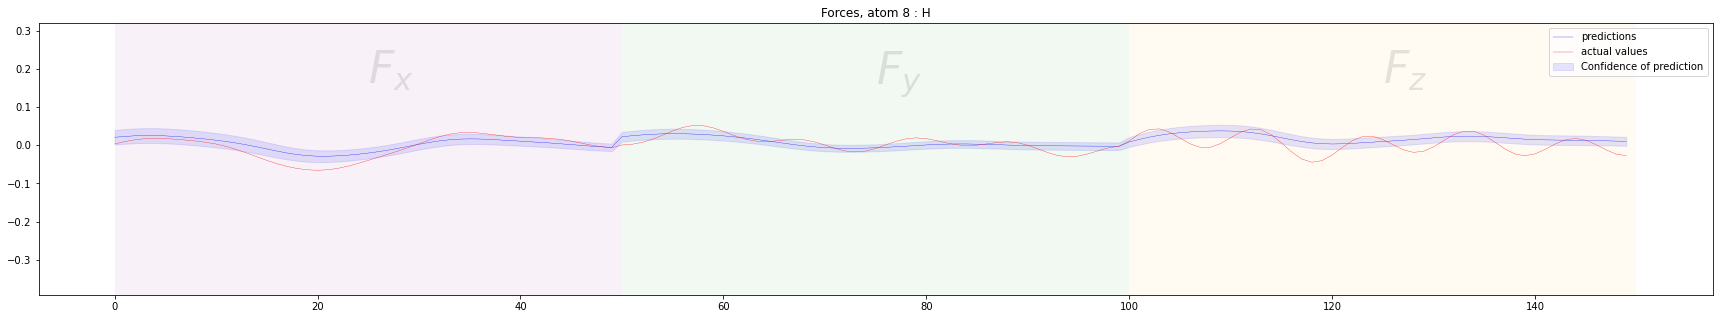

Forces MAE: 0.0154
Forces MSE: 0.0004
Cumulative uncertainty: 3.9368


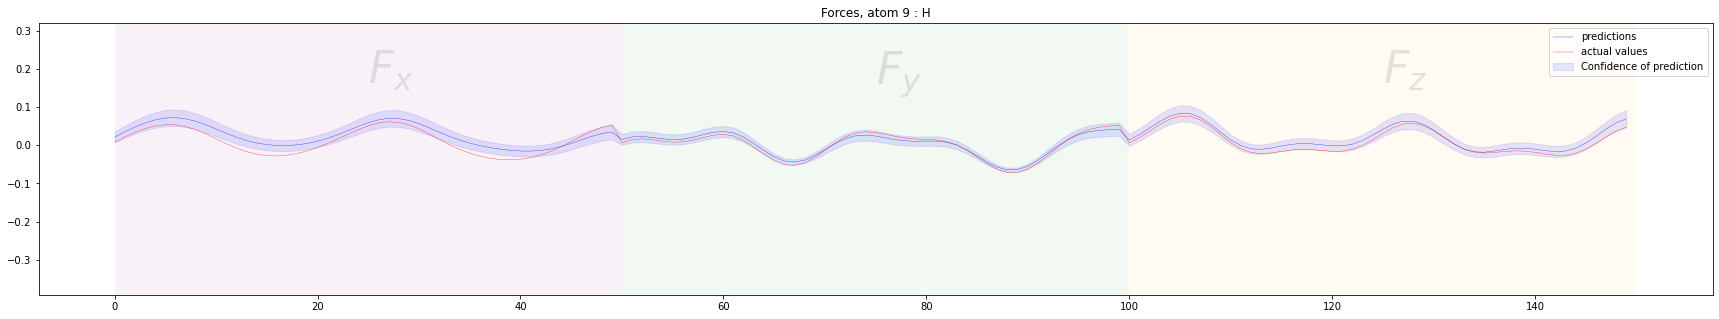

Forces MAE: 0.0112
Forces MSE: 0.0002
Cumulative uncertainty: 4.5736


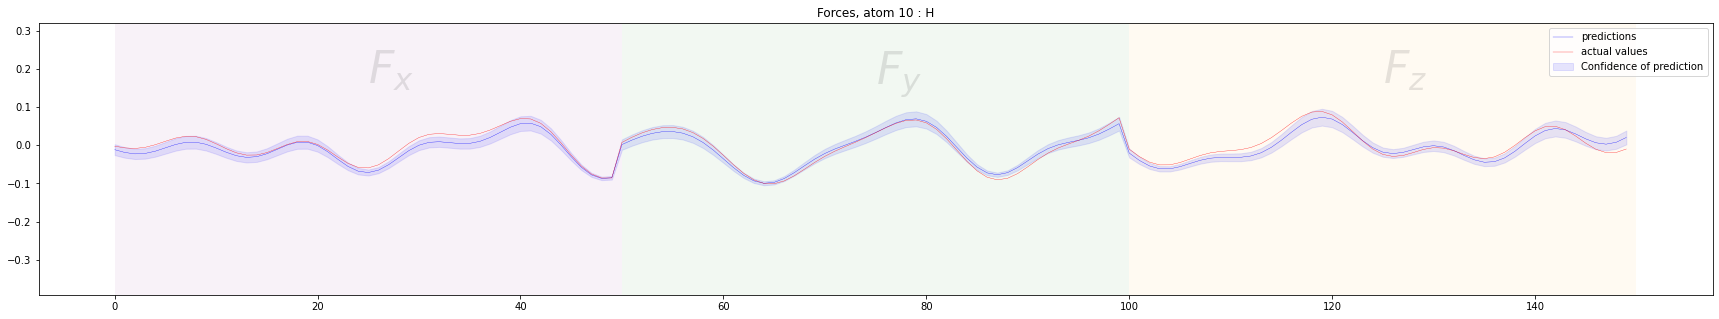

Forces MAE: 0.0104
Forces MSE: 0.0002
Cumulative uncertainty: 4.0050


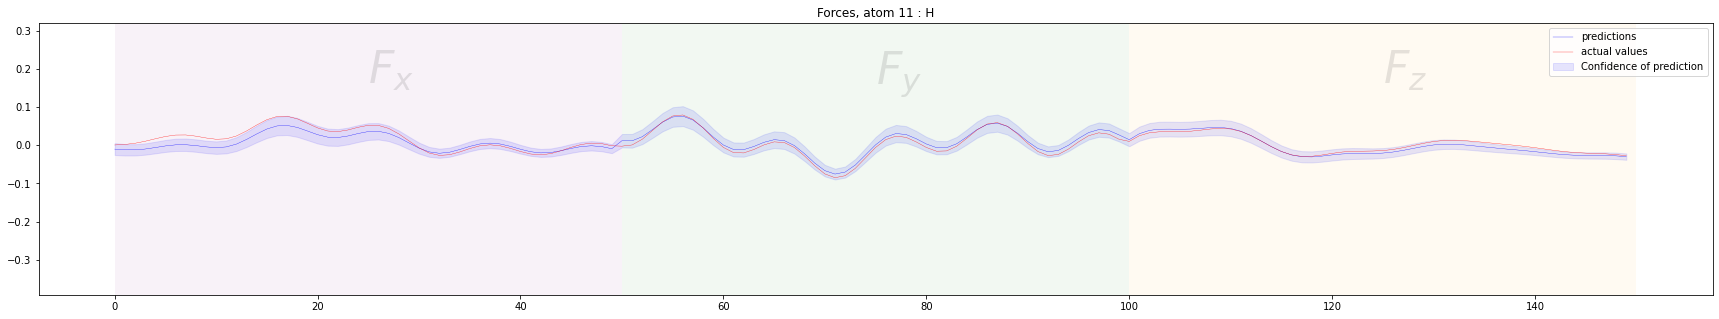

Forces MAE: 0.0087
Forces MSE: 0.0001
Cumulative uncertainty: 4.9599


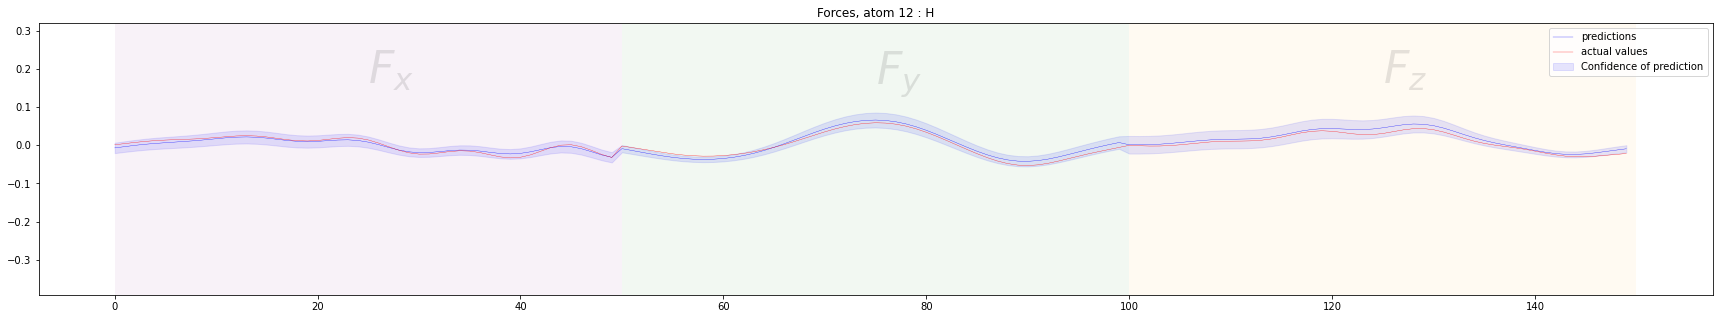

Forces MAE: 0.0064
Forces MSE: 0.0001
Cumulative uncertainty: 4.6860


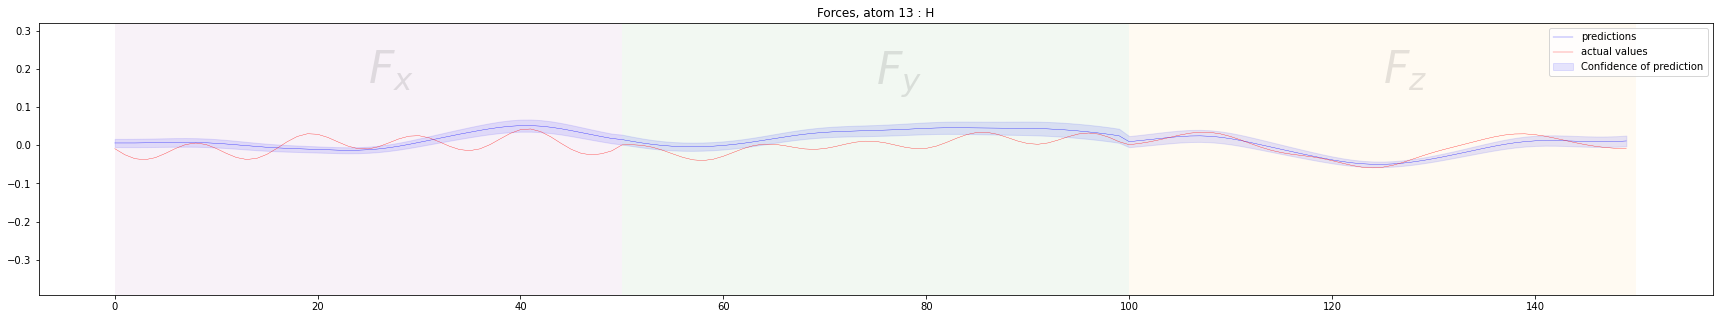

Forces MAE: 0.0204
Forces MSE: 0.0006
Cumulative uncertainty: 3.7504


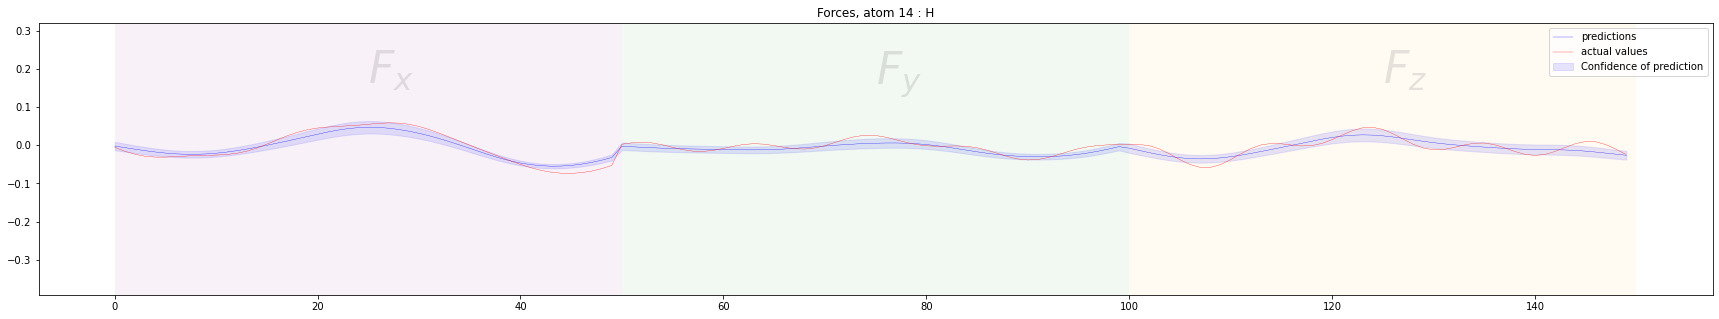

Forces MAE: 0.0104
Forces MSE: 0.0001
Cumulative uncertainty: 3.2946


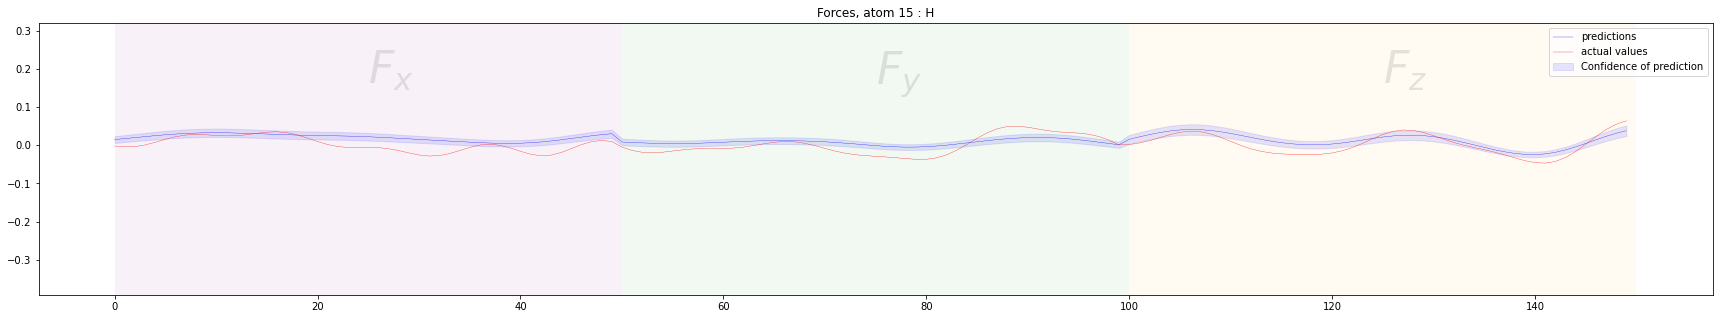

Forces MAE: 0.0175
Forces MSE: 0.0004
Cumulative uncertainty: 2.9340


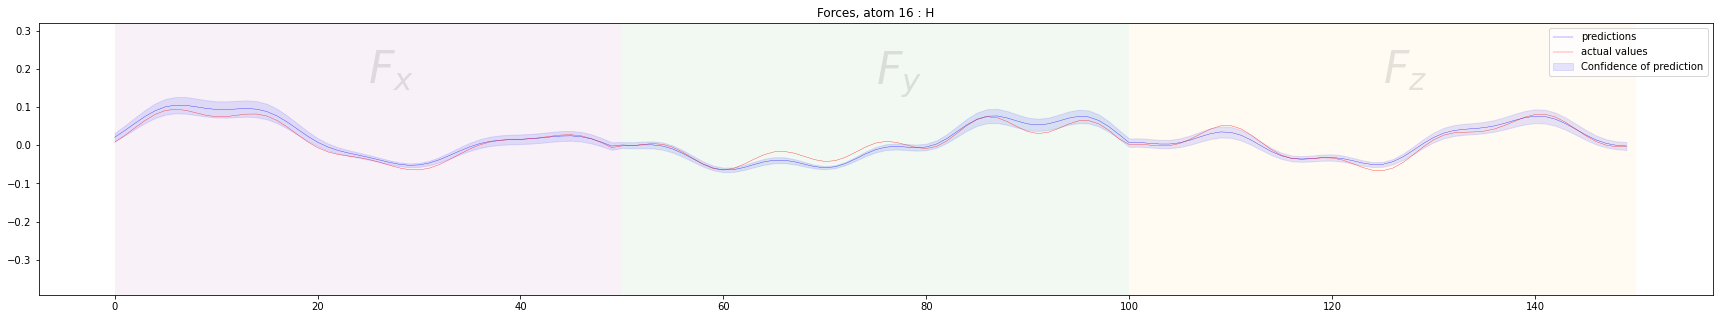

Forces MAE: 0.0086
Forces MSE: 0.0001
Cumulative uncertainty: 3.5199


In [1263]:
from fande.predict import PredictorASE

test_X = fdm.test_X
test_DX = fdm.test_DX
test_E = fdm.test_E
test_F = fdm.test_F

model_e = None
trainer_e = None


predictor = PredictorASE(
        fdm,
            model_e,
            model_f,
            trainer_e,
            trainer_f,
            test_X,
            test_DX,
            test_E,
            test_F,
            test_data,
            hparams,
            soap_params
)


predictor.predict_and_plot_forces()

In [1262]:
# %%capture
from ase.units import Bohr,Hartree

test_f = []

for mol in fdm.traj_test:
        f_, f_var_ = predictor.predict_forces_single(mol)
        # print(f_[16,0])
        test_f.append(f_[16,0])

# print(f_)

# print(f_[16]) 
# print(fdm.forces_test_norm[5,16,:])

plt.plot(fdm.forces_test[:,16,0] * Hartree/Bohr)
# print(f_[:,16,0])

plt.plot(test_f)

/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1747274/1889754866.py", line 7, in <cell line: 6>
    f_, f_var_ = predictor.predict_forces_single(mol)
  File "/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks/../../fande/fande/predict/predictors_ase.py", line 411, in predict_forces_single
    f_ = self.get_xtb_forces(snapshot)
  File "/home/dlb/coding/shared_coding/repos/chem-gp/saddle-dynamics/notebooks/../../fande/fande/predict/predictors_ase.py", line 494, in get_xtb_forces
    atoms_.calc = self.xtb_calc
AttributeError: 'PredictorASE' object has no attribute 'xtb_calc'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1

### Dynamics simulation

In [ ]:
from sdynamics.dynamics import MDynamics

atoms = ... # initialize saddle structure

atoms.calc = gp_model.ase_calc() # get calc from the trained GP

md_runner = MDynamics(atoms) # instantiate class for running MD

md_runner.run() # run the MD

### Testing ASE calc

In [1279]:
%%time
from fande.ase import FandeCalc
from ase.build import molecule

from ase import io

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.INFO) # logging.ERROR to disable or INFO


logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)


atoms = fdm.traj_train[100].copy()

# atoms = molecule("CH3CH2OCH3")
fande_calc = FandeCalc(predictor)

# for a in traj: a.calc=fande_calc 
atoms.calc = fande_calc

print(atoms.get_potential_energy() )
print( atoms.get_forces())


Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
-542.1639000203849
[[-0.10594412 -0.45908225 -0.29277246]
 [ 0.61034834  0.4383901   0.20935993]
 [ 0.33447332  0.82477695  0.69333589]
 [-0.11148175 -0.01252607  0.22294673]
 [ 0.15783987 -0.15579642 -0.4475599 ]
 [-0.48184219  0.12007389  0.66703446]
 [ 0.32438669  0.10934117  0.02461919]
 [-0.01063751 -0.09661806 -0.24968446]
 [ 0.03245938  0.07487417  0.00210842]
 [-0.31195693 -0.01455698 -0.57607283]
 [-0.09039736  0.12635891  0.22967071]
 [ 0.07020966 -0.11702959 -0.07040354]
 [-0.06066155 -0.22897022 -0.19885863]
 [ 0.03264087 -0.14197292  0.09067633]
 [-0.17744382 -0.14035702 -0.15111249]
 [-0.02723401  0.0483343  -0.15314693]
 [ 0.02616669  0.14953829  0.07810455]]
CPU times: user 40.1 ms, sys: 0 ns, total: 40.1 ms
Wall time: 36.5 ms


In [ ]:
### Molecular Dynamics with Fande calculator

In [1098]:
from sdynamics import MDRunner

In [1272]:
# %%capture
from sdynamics import MDRunner

# atoms = fdm.mol_traj[10].copy()
atoms = fdm.traj_train[0].copy()
atoms.calc = FandeCalc(predictor)

# print( atoms.get_forces() )
# print( atoms.get_potential_energy())

mdr = MDRunner(atoms, "../data/dump/ase/md_test.xyz", "../data/dump/ase/md_log.log")
mdr.run()

Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() callback called...
Starting SOAP calculation...
SOAP calculation done!

 setup() callback called...

 on_predict_start() callback called...
Predicting: 100%|██████████| 1/1 [00:00<?, ?it/s]

 teardown() call

In [1273]:
traj_ml = io.read("../data/dump/asemd.traj", index=":")
view(traj_ml)

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>

Traceback (most recent call last):
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 32, in <module>
    main()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/ase/gui/pipe.py", line 28, in main
    plt.show()
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib/pyplot.py", line 368, in show
    return _backend_mod.show(*args, **kwargs)
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/home/dlb/anaconda3/envs/pyc/lib/python3.9/site-packages/IPython/core/display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed file.


### Visualize:

In [519]:
from ase.visualize import view

# trj = trajectories[trj_files_basename[2]]
view(traj[0:100])
# view(traj[0:100])

<Popen: returncode: None args: ['/home/dlb/anaconda3/envs/pyc/bin/python', '...>